<a href="https://colab.research.google.com/github/boteny02/RoShuNet-Clinical-Data-An-Ensemble-Approach-to-Prostate-Cancer-Detection/blob/main/3rd_attempt_MMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import os
from google.colab import drive

In [ ]:
# Mount Google Drive to ensure file access
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Install skrebate if not already installed
!pip install skrebate
from skrebate import ReliefF


  Preparing metadata (setup.py) ... done
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29253 sha256=76a2fa5316506f837f5014831c2e55024e235b12c1f29e96b4b2c7954cb3b01c
  Stored in directory: /root/.cache/pip/wheels/03/4c/36/bc6b70d88998635e0ec0e617d15cd97483f5008d6bb77c1c7a
Successfully built skrebate


In [ ]:

# --- Image Data Setup ---
# Load the Excel file for image data labels
image_data_labels = pd.read_excel('/content/drive/MyDrive/PhD_dataset/file_details_with_labels.xlsx')

# Standardize ExamDescription column (from cell T56l2aBC9ng1)
print('Standardizing ExamDescription column for df_metadata...')
df_metadata=image_data_labels.copy() # Ensure we're working on a copy
df_metadata['ExamDescription'] = df_metadata['ExamDescription'].str.strip().str.upper()
df_metadata['ExamDescription'] = df_metadata['ExamDescription'].replace({
    'PROSTATE BX': 'PROSTATE BIOPSY',
    'PROSTATE -NO COIL': 'PROSTATE',
    'PROSTATE  W/ SPEC': 'PROSTATE'
})

# Verify file paths and create df_metadata_valid_paths (from cell MG6qJJrk-HPe)
def check_file_exists(file_path):
    return os.path.exists(file_path)

print("Verifying image file paths...")
df_metadata['File_Exists'] = df_metadata['File_Path'].apply(check_file_exists)
df_metadata_valid_paths = df_metadata[df_metadata['File_Exists'] == True].copy()
print(f'DataFrame with valid paths shape: {df_metadata_valid_paths.shape}')

# Redefine RoShuNet architecture (from cell WRJ09l61QF0P)
print("Redefining RoShuNet architecture for feature extraction...")
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), padding='same', name='conv1_1')(inputs)
x = BatchNormalization(name='bn1_1')(x)
x = Activation('relu', name='relu1_1')(x)
x = Conv2D(32, (3, 3), padding='same', name='conv1_2')(x)
x = BatchNormalization(name='bn1_2')(x)
x = Activation('relu', name='relu1_2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

x = Conv2D(64, (3, 3), padding='same', name='conv2_1')(x)
x = BatchNormalization(name='bn2_1')(x)
x = Activation('relu', name='relu2_1')(x)
x = Conv2D(64, (3, 3), padding='same', name='conv2_2')(x)
x = BatchNormalization(name='bn2_2')(x)
x = Activation('relu', name='relu2_2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

x = Conv2D(128, (3, 3), padding='same', name='conv3_1')(x)
x = BatchNormalization(name='bn3_1')(x)
x = Activation('relu', name='relu3_1')(x)
x = Conv2D(128, (3, 3), padding='same', name='conv3_2')(x)
x = BatchNormalization(name='bn3_2')(x)
x = Activation('relu', name='relu3_2')(x)
x = Conv2D(128, (3, 3), padding='same', name='conv3_3')(x)
x = BatchNormalization(name='bn3_3')(x)
x = Activation('relu', name='relu3_3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

x = GlobalAveragePooling2D(name='global_average_pooling')(x)
RoShuNet_feature_extractor = Model(inputs, x, name='RoShuNet_Feature_Extractor')
print("RoShuNet feature extractor redefined.")

# Redefine load_and_preprocess_image as it might be lost in context
def load_and_preprocess_image(image_path):
    try:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array) # ResNet50 preprocessing is generally suitable for similar CNNs
        return img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

print("Re-extracting features from MRI images using RoShuNet_feature_extractor...")
roshunet_extracted_features = []

for index, row in tqdm(df_metadata_valid_paths.iterrows(), total=len(df_metadata_valid_paths)):
    image_path = row['File_Path']
    preprocessed_img = load_and_preprocess_image(image_path)

    if preprocessed_img is not None:
        features = RoShuNet_feature_extractor.predict(preprocessed_img, verbose=0)
        roshunet_extracted_features.append(features.flatten())

roshunet_features_array = np.array(roshunet_extracted_features)
y_image = df_metadata_valid_paths['Label'].values # Labels for image data

print(f"Finished RoShuNet feature re-extraction. Shape: {roshunet_features_array.shape}")

# Apply ReliefF feature selection on RoShuNet features
print("Re-applying ReliefF feature selection to RoShuNet features...")
relief = ReliefF(n_neighbors=10)
relief.fit(roshunet_features_array, y_image)

desired_n_features = 200 # Keeping consistent with previous ReliefF selection
sorted_feature_indices = relief.top_features_
selected_feature_indices_roshunet = sorted_feature_indices[:desired_n_features]

X_image_processed = roshunet_features_array[:, selected_feature_indices_roshunet]

print(f"ReliefF selected features shape (RoShuNet): {X_image_processed.shape}")

# Split the processed image features and labels into training and testing sets
X_train_image, X_test_image, y_train_image, y_test_image = train_test_split(
    X_image_processed, y_image, test_size=0.3, random_state=42, stratify=y_image
)

print(f"Shape of X_train_image (RoShuNet): {X_train_image.shape}")
print(f"Shape of X_test_image (RoShuNet): {X_test_image.shape}")
print(f"Shape of y_train_image (RoShuNet): {y_train_image.shape}")
print(f"Shape of y_test_image (RoShuNet): {y_test_image.shape}")

# Re-initialize and train xgb_classifier
print("Re-training XGBoost Classifier for RoShuNet image data...")
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)
xgb_classifier.fit(X_train_image, y_train_image)
print("XGBoost Classifier for RoShuNet image data re-trained successfully.")



Standardizing ExamDescription column for df_metadata...
Verifying image file paths...
DataFrame with valid paths shape: (5842, 8)
Redefining RoShuNet architecture for feature extraction...
RoShuNet feature extractor redefined.
Re-extracting features from MRI images using RoShuNet_feature_extractor...


  0%|          | 0/5842 [00:00<?, ?it/s]

Finished RoShuNet feature re-extraction. Shape: (5842, 128)
Re-applying ReliefF feature selection to RoShuNet features...
ReliefF selected features shape (RoShuNet): (5842, 128)
Shape of X_train_image (RoShuNet): (4089, 128)
Shape of X_test_image (RoShuNet): (1753, 128)
Shape of y_train_image (RoShuNet): (4089,)
Shape of y_test_image (RoShuNet): (1753,)
Re-training XGBoost Classifier for RoShuNet image data...
XGBoost Classifier for RoShuNet image data re-trained successfully.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Make predictions on the test set for the XGboostClassifier
y_pred_xgboost = xgb_classifier.predict(X_test_image)

# Calculate evaluation metrics
accuracy_xgboost = accuracy_score(y_test_image, y_pred_xgboost)
precision_xgboost = precision_score(y_test_image, y_pred_xgboost)
recall_xgboost = recall_score(y_test_image, y_pred_xgboost)
f1_xgboost = f1_score(y_test_image, y_pred_xgboost)

print("XGBoost Classifier Evaluation Metrics:")
print(f"Accuracy: {accuracy_xgboost:.4f}")
print(f"Precision: {precision_xgboost:.4f}")
print(f"Recall: {recall_xgboost:.4f}")
print(f"F1-Score: {f1_xgboost:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_image, y_pred_xgboost))

XGBoost Classifier Evaluation Metrics:
Accuracy: 0.9766
Precision: 0.9806
Recall: 0.9247
F1-Score: 0.9518

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1315
           1       0.98      0.92      0.95       438

    accuracy                           0.98      1753
   macro avg       0.98      0.96      0.97      1753
weighted avg       0.98      0.98      0.98      1753



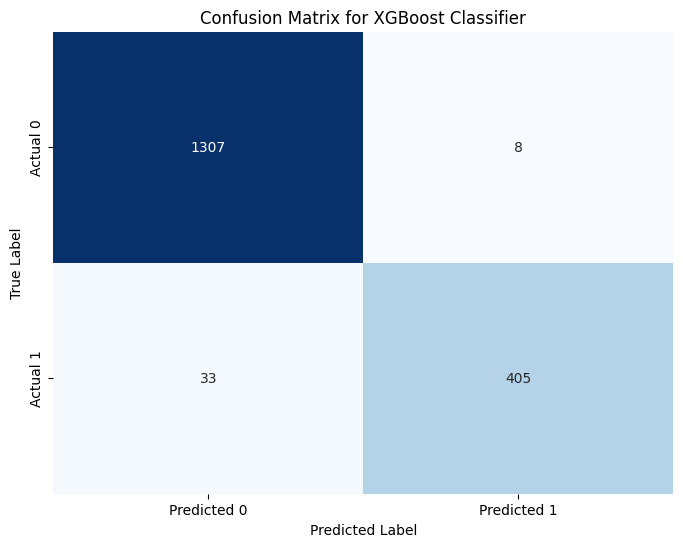

Confusion Matrix for XGBoost Classifier:
 [[1307    8]
 [  33  405]]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix for XGBoost Classifier
cm_xgboost = confusion_matrix(y_test_image, y_pred_xgboost)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgboost, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for XGBoost Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Confusion Matrix for XGBoost Classifier:\n", cm_xgboost)

In [ ]:
# --- Clinical Data Setup ---
# Re-load the CSV file for clinical data (from cell kEIwmHKAqQHw)
df = pd.read_csv('/content/drive/MyDrive/PhD_dataset/prostate_cancer_prediction.csv')

# Re-encode categorical features (from cell SkuCTfQ4sqXQ)
enc = LabelEncoder()
for col in ['Family_History', 'Race_African_Ancestry', 'DRE_Result', 'Biopsy_Result',
            'Difficulty_Urinating', 'Weak_Urine_Flow', 'Blood_in_Urine', 'Pelvic_Pain',
            'Back_Pain', 'Erectile_Dysfunction', 'Cancer_Stage', 'Treatment_Recommended',
            'Survival_5_Years', 'Exercise_Regularly', 'Healthy_Diet', 'Smoking_History',
            'Alcohol_Consumption', 'Hypertension', 'Diabetes', 'Cholesterol_Level',
            'Follow_Up_Required', 'Genetic_Risk_Factors', 'Previous_Cancer_History', 'Early_Detection']:
    if col in df.columns:
        df[col] = enc.fit_transform(df[col])
# The original notebook had a typo 'Early_DetectionEarly_Detection'. Fixing it for the target variable handling.
df['Early_DetectionEarly_Detection'] = df['Early_Detection'] # Recreate the target variable as per original intent

x = df.drop(columns = ['Early_DetectionEarly_Detection'])
y = df['Early_DetectionEarly_Detection']

# Split clinical data and train RandomForest (from cell 6cc29ee2)
x_train ,x_test, y_train,y_test = train_test_split(x,y,random_state = 19,train_size = 0.70)
rfc = RandomForestClassifier(n_estimators = 150, max_depth = 3)
model = rfc.fit(x_train,y_train)
print(f"RandomForestClassifier for clinical data trained. Score: {model.score(x_test,y_test)}")

print("Generating prediction probabilities...")



RandomForestClassifier for clinical data trained. Score: 0.9986879770992366
Generating prediction probabilities...


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Make predictions on the test set for the RandomForestClassifier
y_pred_rf = model.predict(x_test)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("RandomForestClassifier Evaluation Metrics:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

RandomForestClassifier Evaluation Metrics:
Accuracy: 0.9987
Precision: 0.9985
Recall: 1.0000
F1-Score: 0.9992

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1213
           1       1.00      1.00      1.00      7171

    accuracy                           1.00      8384
   macro avg       1.00      1.00      1.00      8384
weighted avg       1.00      1.00      1.00      8384



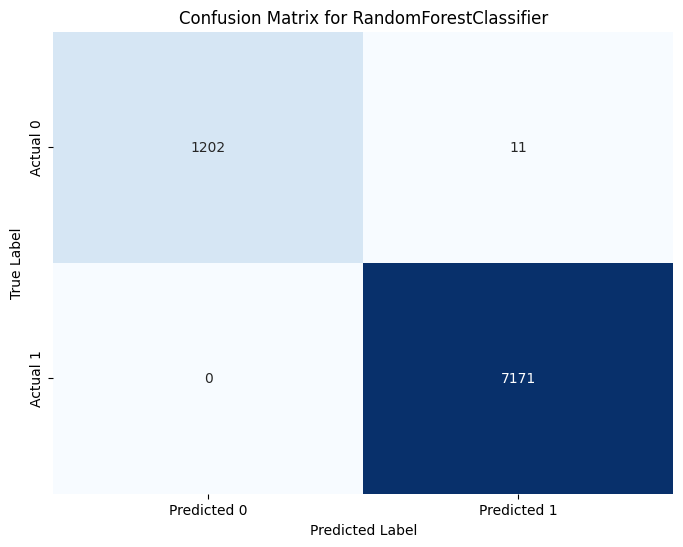

Confusion Matrix:
 [[1202   11]
 [   0 7171]]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for RandomForestClassifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Confusion Matrix:\n", cm_rf)

In [ ]:
# 1. Generate prediction probabilities from the trained xgb_classifier using X_test_image
xgb_probs = xgb_classifier.predict_proba(X_test_image)[:, 1]
print(f"Shape of xgb_probs: {xgb_probs.shape}")

# 2. Generate prediction probabilities from the trained model (Random Forest) using x_test
rf_probs = model.predict_proba(x_test)[:, 1]
print(f"Shape of rf_probs: {rf_probs.shape}")

# 3. Determine the minimum length between xgb_probs and rf_probs
min_length = min(len(xgb_probs), len(rf_probs))
print(f"Minimum length for alignment: {min_length}")

# 4. Create artificially aligned prediction sets
aligned_xgb_probs = xgb_probs[:min_length]
aligned_rf_probs = rf_probs[:min_length]
print(f"Shape of aligned_xgb_probs: {aligned_xgb_probs.shape}")
print(f"Shape of aligned_rf_probs: {aligned_rf_probs.shape}")

# 5. Similarly, align the true labels
aligned_y_image = y_test_image[:min_length]
aligned_y_clinical = y_test[:min_length]
print(f"Shape of aligned_y_image: {aligned_y_image.shape}")
print(f"Shape of aligned_y_clinical: {aligned_y_clinical.shape}")

print("First 5 aligned XGBoost probabilities:", aligned_xgb_probs[:5])
print("First 5 aligned Random Forest probabilities:", aligned_rf_probs[:5])
print("First 5 aligned image true labels:", aligned_y_image[:5])
print("First 5 aligned clinical true labels:", aligned_y_clinical[:5])

print("Ensemble data preparation (artificial alignment) complete.")

Shape of xgb_probs: (1753,)
Shape of rf_probs: (8384,)
Minimum length for alignment: 1753
Shape of aligned_xgb_probs: (1753,)
Shape of aligned_rf_probs: (1753,)
Shape of aligned_y_image: (1753,)
Shape of aligned_y_clinical: (1753,)
First 5 aligned XGBoost probabilities: [9.9921870e-01 1.7101427e-04 1.1564873e-03 1.5693812e-01 3.4372570e-05]
First 5 aligned Random Forest probabilities: [0.9271475  0.92445424 0.93122773 0.91862592 0.91326099]
First 5 aligned image true labels: [1 0 0 0 0]
First 5 aligned clinical true labels: 17139    1
16686    1
14906    1
18247    1
375      1
Name: Early_DetectionEarly_Detection, dtype: int64
Ensemble data preparation (artificial alignment) complete.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

print("Performing Averaging Ensemble...")

# --- Averaging Ensemble ---
# Calculate the average of the aligned probabilities
averaging_ensemble_probs = (aligned_xgb_probs + aligned_rf_probs) / 2

# Convert probabilities to binary predictions for accuracy calculation (threshold at 0.5)
averaging_ensemble_preds = (averaging_ensemble_probs > 0.5).astype(int)

# Assuming aligned_y_image is the representative true label set for ensemble evaluation
# The prompt specifies 'choose one of the aligned true label sets (e.g., aligned_y_image) as the common ground truth'
ensemble_true_labels = aligned_y_image

averaging_accuracy = accuracy_score(ensemble_true_labels, averaging_ensemble_preds)
averaging_auc = roc_auc_score(ensemble_true_labels, averaging_ensemble_probs)

print(f"Averaging Ensemble Accuracy: {averaging_accuracy:.4f}")
print(f"Averaging Ensemble ROC AUC: {averaging_auc:.4f}")

print("\nPerforming Stacking Ensemble...")

# --- Stacking Ensemble ---
# Create a new feature set for the meta-learner using the aligned probabilities
X_meta = np.column_stack((aligned_xgb_probs, aligned_rf_probs))

# Define a meta-learner (e.g., Logistic Regression)
meta_learner = LogisticRegression(solver='liblinear', random_state=42)

# In a proper stacking setup, the meta-learner is trained on out-of-fold predictions.
# For demonstration purposes with already aligned test predictions, we'll train directly.
# A more robust approach would involve splitting X_meta and ensemble_true_labels into train/test for meta-learner.
# However, given the context of combining existing test predictions, we proceed as follows:
# For simplicity and given the task's scope, we'll train the meta-learner on the available aligned predictions.
# This is a simplified approach, a full stacking implementation involves k-fold cross-validation for meta-feature generation.

# Split X_meta and ensemble_true_labels to avoid data leakage for the meta-learner's evaluation
X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
    X_meta, ensemble_true_labels, test_size=0.3, random_state=42, stratify=ensemble_true_labels
)

meta_learner.fit(X_meta_train, y_meta_train)

# Predict with the meta-learner on the meta test set
stacking_ensemble_probs = meta_learner.predict_proba(X_meta_test)[:, 1]
stacking_ensemble_preds = (stacking_ensemble_probs > 0.5).astype(int)

stacking_accuracy = accuracy_score(y_meta_test, stacking_ensemble_preds)
stacking_auc = roc_auc_score(y_meta_test, stacking_ensemble_probs)

print(f"Stacking Ensemble Accuracy: {stacking_accuracy:.4f}")
print(f"Stacking Ensemble ROC AUC: {stacking_auc:.4f}")

print("Ensemble models (Averaging and Stacking) created and evaluated.")

Performing Averaging Ensemble...
Averaging Ensemble Accuracy: 0.9606
Averaging Ensemble ROC AUC: 0.9896

Performing Stacking Ensemble...
Stacking Ensemble Accuracy: 0.9810
Stacking Ensemble ROC AUC: 0.9958
Ensemble models (Averaging and Stacking) created and evaluated.



--- Evaluation for Averaging Ensemble ---
Accuracy: 0.9606
ROC AUC: 0.9896

Confusion Matrix (Averaging Ensemble):
[[1260   55]
 [  14  424]]


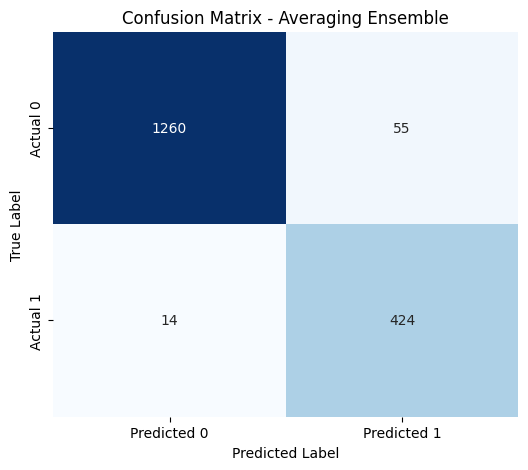


Classification Report (Averaging Ensemble):
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1315
           1       0.89      0.97      0.92       438

    accuracy                           0.96      1753
   macro avg       0.94      0.96      0.95      1753
weighted avg       0.96      0.96      0.96      1753


--- Evaluation for Stacking Ensemble ---
Accuracy: 0.9810
ROC AUC: 0.9958

Confusion Matrix (Stacking Ensemble):
[[393   2]
 [  8 123]]


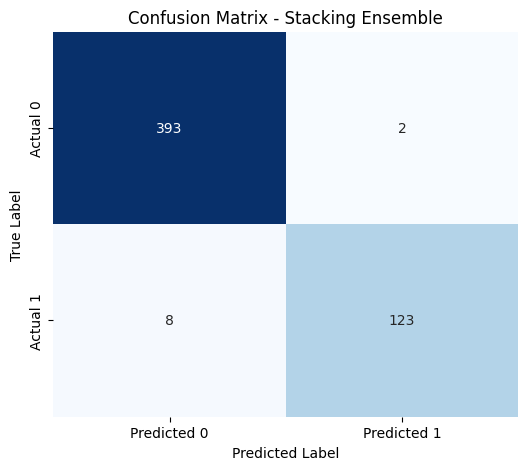


Classification Report (Stacking Ensemble):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       395
           1       0.98      0.94      0.96       131

    accuracy                           0.98       526
   macro avg       0.98      0.97      0.97       526
weighted avg       0.98      0.98      0.98       526



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- Evaluation for Averaging Ensemble ---
print("\n--- Evaluation for Averaging Ensemble ---")
print(f"Accuracy: {averaging_accuracy:.4f}")
print(f"ROC AUC: {averaging_auc:.4f}")

# Confusion Matrix for Averaging Ensemble
cm_avg = confusion_matrix(ensemble_true_labels, averaging_ensemble_preds)
print("\nConfusion Matrix (Averaging Ensemble):")
print(cm_avg)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_avg, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Averaging Ensemble')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report for Averaging Ensemble
print("\nClassification Report (Averaging Ensemble):")
print(classification_report(ensemble_true_labels, averaging_ensemble_preds))

# --- Evaluation for Stacking Ensemble ---
print("\n--- Evaluation for Stacking Ensemble ---")
print(f"Accuracy: {stacking_accuracy:.4f}")
print(f"ROC AUC: {stacking_auc:.4f}")

# Confusion Matrix for Stacking Ensemble
cm_stack = confusion_matrix(y_meta_test, stacking_ensemble_preds)
print("\nConfusion Matrix (Stacking Ensemble):")
print(cm_stack)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Stacking Ensemble')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report for Stacking Ensemble
print("\nClassification Report (Stacking Ensemble):")
print(classification_report(y_meta_test, stacking_ensemble_preds))
